In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

### Download pretrained image classifier from tf-hub

In [2]:
model = tf.keras.Sequential([
       hub.KerasLayer(
           name = 'inception_v1',
           handle = 'https://tfhub.dev/google/imagenet/inception_v1/classification/4',
           trainable = False),
])

model.build([None,224,224,3])
## This is a dense 4D tensor of dtype float32 and shape (batch_size,height,width,RGB channels) 
# whose elements are RGB color values of pixels normalized to the range[0,1]. The first element is None to 
# indicate that the model  can take any integer batch size
model.summary()

#Output will be a tf.Tensor of logits in the shape of (batch_size, 1001). 
# Each row represents the model's predicted score for each of 1,001 classes 
# from ImageNet. For the model's top predicted class index you can use 
# tf.argmax(predictions, axis=-1). Furthermore, you can also convert the model's 
# logit output to predicted probabilities across all classes using tf.nn.softmax(predictions, axis=-1)
# to quantify the model's uncertainty as well as explore similar predicted classes for debugging.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v1 (KerasLayer)    (None, 1001)              6633209   
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


In [3]:
def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt',file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
    return np.array(labels)


In [4]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

### Load and preprocess image with tf.image

In [5]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.image.decode_jpeg(image,channels=3)
  image = tf.image.convert_image_dtype(image,tf.float32)
  image = tf.image.resize_with_pad(image,target_height=224,target_width=224)

  return image

In [6]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
    'dogandcat': 'https://i.imgur.com/VLbQDCg.jpeg'
    
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

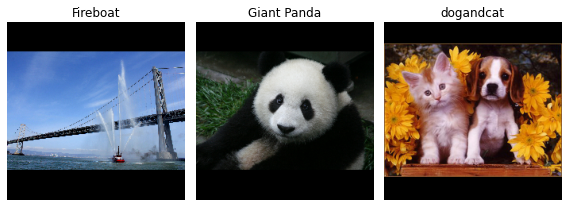

In [7]:
plt.figure(figsize=(8,8))

for n, (name,img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1,3,n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()


## Classify Image

#### Classifying the images and displaying the top 5 most confident predictions. Following is a utility function to retrieve the top k predicted labels and probabilitites

In [8]:
def top_k_predictions(img,k=5):
  image_batch = tf.expand_dims(img,0)
  predictions = model(image_batch)
  probs = tf.nn.softmax(predictions,axis=-1)
  top_probs,top_idxs = tf.math.top_k(input=probs,k=k)
  top_labels = imagenet_labels[tuple(top_idxs)]
  return top_labels,top_probs[0]

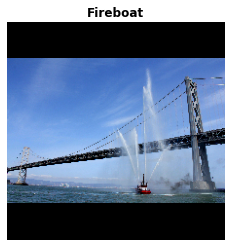

fireboat: 32.6%
pier: 12.7%
suspension bridge: 5.7%
crane: 4.6%
schooner: 2.9%


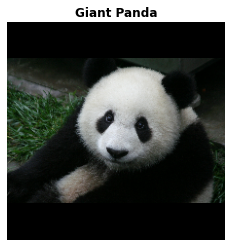

giant panda: 89.4%
teddy: 0.3%
gibbon: 0.3%
colobus: 0.2%
lesser panda: 0.2%


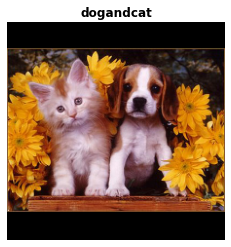

Blenheim spaniel: 29.4%
Japanese spaniel: 4.4%
Welsh springer spaniel: 3.4%
cocker spaniel: 2.3%
Brittany spaniel: 2.2%


In [9]:
for (name, img_tensor) in img_name_tensors.items():
  plt.imshow(img_tensor)
  plt.title(name, fontweight='bold')
  plt.axis('off')
  plt.show()

  pred_label, pred_prob = top_k_predictions(img_tensor)
  for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

### Calculate Integrated Gradients

##### Our model, Inception V1, is a learned function that describes a mapping between your input feature space, image pixel values, and an output space defined by ImageNet class probability values between 0 and 1. Early interpretability methods for neural networks assigned feature importance scores using gradients, which tell you which pixels have the steepest local relative to your model's prediction at a given point along your model's prediction function. However, gradients only describe local changes in your model's prediction function with respect to pixel values and do not fully describe your entire model prediction function. As your model fully "learns" the relationship between the range of an individual pixel and the correct ImageNet class, the gradient for this pixel will saturate, meaning become increasingly small and even go to zero. 

In [10]:
def f(x):
  """A simplified model fxn"""
  return tf.where(x<0.8,x,0.8)

def interpolated_path(x):
  """A straight line path."""
  return tf.zeros_like(x)

x = tf.linspace(start = 0.0,stop=1.0,num=6)
y = f(x)



#### How IG solves the gradient saturation problem

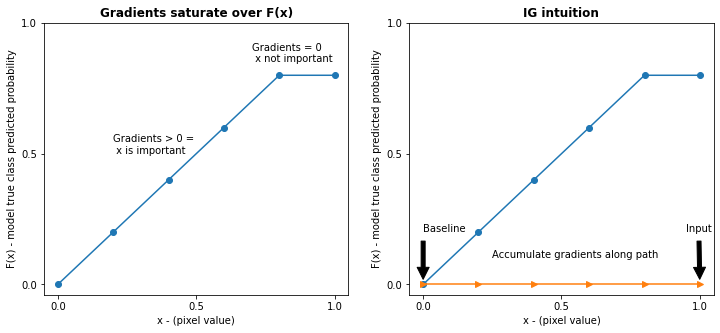

In [11]:
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show();

- left: Our model's gradients for pixel x are positive between 0.0 and 0.8 but go to 0.0 between 0.8 and 1.0. Pixel x clearly has a significant impact on pushing your model toward 80% predicted probability on the true class. Does it make sense that pixel x's importance is small or discontinuous?

- right: The intuition behind IG is to accumulate pixel x's local gradients and attribute its importance as a score for how much it adds or subtracts to your model's overall output class probability. You can break down and compute IG in 3 parts:

1. interpolate small steps along a straight line in the feature space between 0 (a baseline or starting point) and 1 (input pixel's value)
2. compute gradients at each step between your model's predictions with respect to each step
3. approximate the integral between your baseline and input by accumulating (cumulative average) these local gradients.

## Establish a baseline

A baseline is an input image used as a starting point for calculating feature importance. Intuitively, you can think of the baseline's explanatory role as representing the impact of the absence of each pixel on the "Fireboat" prediction to contrast with its impact of each pixel on the "Fireboat" prediction when present in the input image. As a result, the choice of the baseline plays a central role in interpreting and visualizing pixel feature importances. Here, you will use a black image whose pixel values are all zero.

Other choices you could experiment with include an all white image, or a random image, which you can create with tf.random.uniform(shape=(224,224,3), minval=0.0, maxval=1.0)

In [12]:
baseline = tf.zeros(shape=(224,224,3))

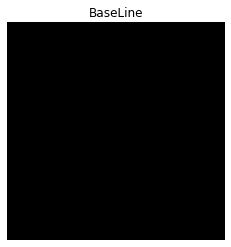

In [13]:
plt.imshow(baseline)
plt.title("BaseLine")
plt.axis('off')
plt.show()

In [14]:
m_steps = 50
alphas = tf.linspace(start=0.0,stop=1.0,num=m_steps+1) # generate m_steps intervals for integral_approximation()

In [15]:
def interpolate_images(baseline,image,alphas):
  alphas_x = alphas[:,tf.newaxis,tf.newaxis,tf.newaxis]
  baseline_x = tf.expand_dims(baseline,axis=0)
  input_x = tf.expand_dims(image,axis=0)
  delta = input_x - baseline_x
  images = baseline_x + alphas_x * delta
  return images


### Using the above function to generate interpolated image along a linear path at alpha intervals between a black baseline image and the example "fireboat" image

In [16]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['Fireboat'],
    alphas=alphas)

### alpha constant is consistently increasing each interpolated image's intensity

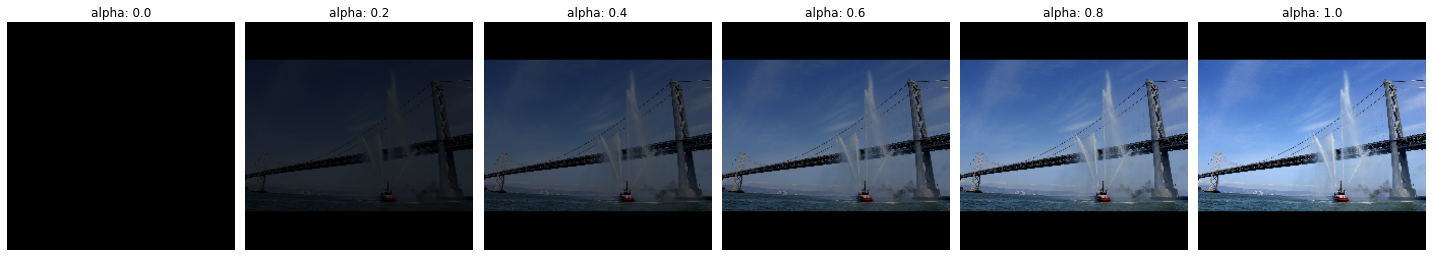

In [17]:
fig = plt.figure(figsize=(20,20))

i = 0
for alpha,image in zip(alphas[0::10],interpolated_images[0::10]):
  i+=1
  plt.subplot(1,len(alphas[0::10]),i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout()

## Computing gradients 



#### Now let's take a look at how to calculate gradients in order to measure the relationship between changes to a feature and changes in the model's predictions. In the case of images, the gradient tells us which pixels have the strongest effect on the models predicted class probabilities.

TensorFlow makes computing gradients easy with a `tf.GradientTape`.

In [18]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

### Let's compute the gradients for each image along the interpolation path with respect to the correct output. Recall that your model returns a (1, 1001) shaped Tensor with logits that you convert to predicted probabilities for each class. You need to pass the correct ImageNet target class index to the compute_gradients function for your image.

In [19]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=555)

Note the output shape of (n_interpolated_images, img_height, img_width, RGB), which gives us the gradient for every pixel of every image along the interpolation path. You can think of these gradients as measuring the change in your model's predictions for each small step in the feature space.

In [20]:
print(path_gradients.shape)

(51, 224, 224, 3)


### Visualising gradient saturation

 Note the output shape of (n_interpolated_images, img_height, img_width, RGB), 
 which gives us the gradient for every pixel of every image along the interpolation path. 
 You can think of these gradients as measuring the change in your model's predictions for 
 each small step in the feature space.

## Visualising gradient saturation

Recall that the gradients you just calculated above describe local changes to your model's predicted probability of "Fireboat" and can saturate.

These concepts are visualized using the gradients you calculated above in the 2 plots below.

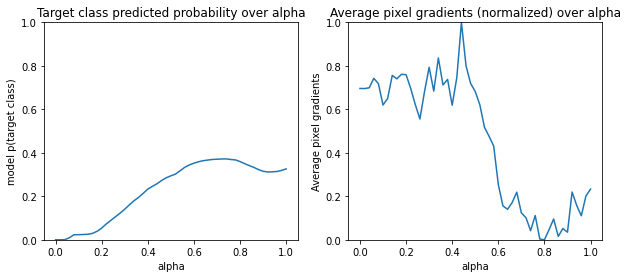

In [21]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 555]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

- left: This plot shows how your model's confidence in the "Fireboat" class varies across alphas. Notice how the gradients, or slope of the line, largely flattens or saturates between 0.6 and 1.0 before settling at the final "Fireboat" predicted probability of about 40%.

- right: The right plot shows the average gradients magnitudes over alpha more directly. Note how the values sharply approach and even briefly dip below zero. In fact, your model "learns" the most from gradients at lower values of alpha before saturating. Intuitively, you can think of this as your model has learned the pixels e.g. water cannons to make the correct prediction, sending these pixels gradients to zero, but is still quite uncertain and focused on spurious bridge or water jet pixels as the alpha values approach the original input image.

### Accumulate Gradients(integral approximation)

There are many different ways you can go about computing the numerical approximation of an integral for IG with different tradeoffs in accuracy and convergence across varying functions. A popular class of methods is called Riemann sums. Here, you will use the Trapezoidal rule

In [22]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:] / tf.constant(2.0))
  integrated_gradients = tf.math.reduce_mean(grads,axis=0)
  return integrated_gradients

The `integral_approximation` function takes the gradients of the predicted probability of the target class with respect to the interpolated images between the baseline and the original image.

In [23]:
ig = integral_approximation(
    gradients=path_gradients)

In [24]:
ig

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[-3.45596345e-04, -4.00817225e-05,  1.20785926e-03],
        [ 2.86333077e-03,  1.79082068e-04,  1.62243797e-03],
        [ 1.04017304e-02,  4.64935554e-03,  4.03311662e-03],
        ...,
        [ 6.31109346e-03,  8.53920542e-03,  5.96543262e-03],
        [-1.12134600e-02, -9.17956792e-03, -6.29616063e-03],
        [-8.05621967e-03, -8.42290744e-03, -5.75531134e-03]],

       [[-4.86238720e-03, -8.33145343e-03, -3.24946665e-03],
        [ 6.25526439e-03,  1.41406269e-03,  3.31013835e-05],
        [ 2.03884263e-02,  1.35858487e-02,  3.76679027e-03],
        ...,
        [ 4.29363595e-03,  1.45660876e-03,  2.53119739e-03],
        [-5.29879378e-03, -5.10565238e-03, -1.36490643e-03],
        [-5.29383542e-03, -4.43682913e-03, -1.10509538e-03]],

       [[-5.17916214e-03, -7.31777120e-03, -3.20977438e-03],
        [-1.94663089e-03, -6.20221440e-03, -4.61993879e-03],
        [-8.71748850e-03, -1.69828646e-02, -1.91925187e-02],


In [25]:
print(ig.shape)

(224, 224, 3)


In [26]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  
  # 1. Genarate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0,num=m_steps+1)

  # Initialize TensorArray outside loop to collect gradients
  gradient_batches = tf.TensorArray(tf.float32,size=m_steps+1)

  # Iterate alphas range and batch computation for speed,memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs b/w baseline and input
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas = alpha_batch)
    
    #3. Compute gradients b/w model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    
    # write batch indices and gradients to extend TensorArray
    gradient_batches = gradient_batches.scatter(tf.range(from_,to),gradient_batch)

  #Stack path gradients together row-wise into simple tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients
  avg_gradients = integral_approximation(gradients=total_gradients)

  # 5. Scale integrated gradients with respect to input
  integrated_gradients = (image-baseline) * avg_gradients

  return integrated_gradients

  

In [27]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img_name_tensors['Fireboat'],
                                       target_class_idx=555,
                                       m_steps=240)

In [28]:
print(ig_attributions.shape)

(224, 224, 3)


### Visualise attributions

You are ready to visualize attributions, and overlay them on the original image. The code below sums the absolute values of the integrated gradients across the color channels to produce an attribution mask. This plotting method captures the relative impact of pixels on the model's predictions.

In [29]:
def plot_img_attributions(baseline,image,target_class_idx,m_steps=50,cmap=None,overlay_alpha=0.4):
  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)
  
  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.

  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig



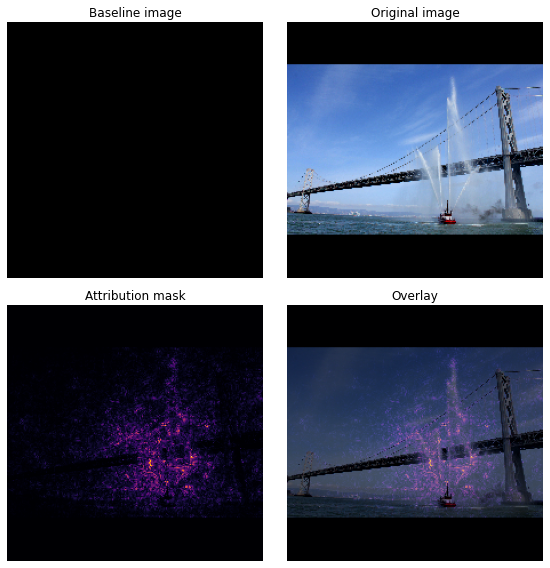

In [30]:
_ = plot_img_attributions(image=img_name_tensors['Fireboat'],
                          baseline=baseline,
                          target_class_idx=555,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

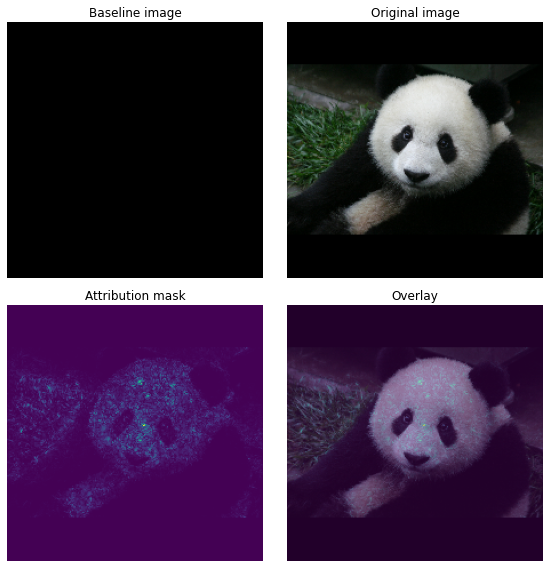

In [31]:
_ = plot_img_attributions(image=img_name_tensors['Giant Panda'],
                          baseline=baseline,
                          target_class_idx=388,
                          m_steps=55,
                          cmap=plt.cm.viridis,
                          overlay_alpha=0.5)

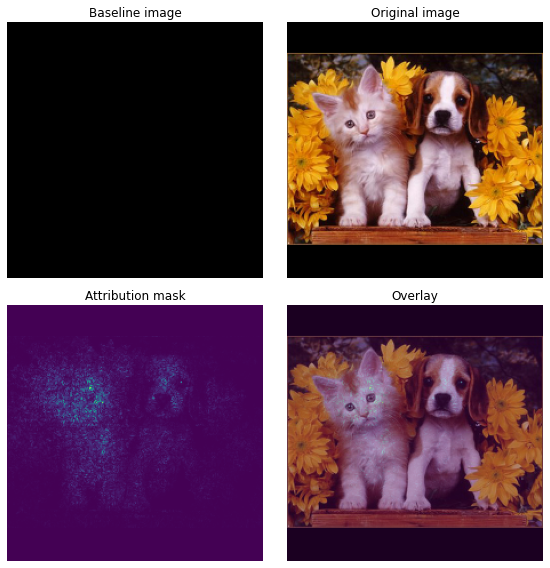

In [32]:
_ = plot_img_attributions(image=img_name_tensors['dogandcat'],
                          baseline=baseline,
                          target_class_idx=283,
                          m_steps=500,
                          cmap=plt.cm.viridis,
                          overlay_alpha=0.6)

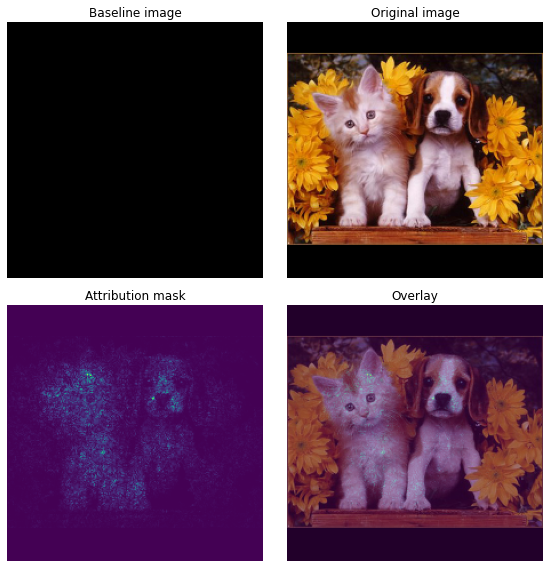

In [34]:
_ = plot_img_attributions(image=img_name_tensors['dogandcat'],
                          baseline=baseline,
                          target_class_idx=156,
                          m_steps=510,
                          cmap=plt.cm.viridis,
                          overlay_alpha=0.5)